# Maximum theoretical yield investigations based on varying carbon sources 

The object of this section is to calculate the theoretical maximum yield of dihydroartesiminic acid using suitable carbon sources. Therefore, the carbon systems found in the GSM should be identified and ranked.

In [1]:
# Libraries to be imported
from cobra.io import read_sbml_model, write_sbml_model # To read the model and save new newly generated model
from cobra import Reaction, Metabolite # To creat new reactions and metabolites
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Define the model based on the dataset in iY0844 with the added reactions:
iY0844_model = read_sbml_model("data/iYO844_modified.xml")

In [3]:
# Simulate base medium in the model:
iY0844_model.medium

{'EX_fe3_e': 999999.0,
 'EX_glc__D_e': 1.7,
 'EX_ca2_e': 999999.0,
 'EX_so4_e': 5.0,
 'EX_co2_e': 999999.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_mg2_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_nh4_e': 5.0,
 'EX_o2_e': 999999.0,
 'EX_pi_e': 5.0}

From this base medium we can see from EX_glc__D_e, that the float defining glucose concentration in the media is 1.7. Therefore, this will be the boundary for the comming analysis. 

First, all carbon exchange reactions in the model are identified. This list is used to establish a baseline to use for later reference.

In [4]:
# Creating empty lists to contain...
carbon_ID = [] #filtered carbon ID
carbon_names = [] #filtered carbon name

# Create a loop where we find all reactions that contains carbon and save them in the lists:
for reaction in iY0844_model.exchanges:
    for metabolite in reaction.reactants:
        if "C" in metabolite.elements:
            carbon_ID.append(reaction.id)
            carbon_names.append(reaction.name) 
            


In [5]:
# Identify max growth rate and max production of DHAA with the current model and medium
with iY0844_model:
    max_base_growth = iY0844_model.slim_optimize()
    print(max_base_growth)
    iY0844_model.objective = iY0844_model.reactions.ALDH1_CYP71AV1
    max_base_production = iY0844_model.slim_optimize()
    print(max_base_production)

0.11796638932239784
0.36342857142856866


Now, a loop going through every carbon source in the model is created, to assess the dihydroartemisinic acid production. The ID's for the different carbon sources are found in BIGG by filtering for _B. subtilis_. 

In [6]:
# Define empty lists for containing values
max_growth = []
max_production = []
# Define medium
medium=iY0844_model.medium
# Create loop for temporary changes in our model to store values in the newly created lists
with iY0844_model:
    for ID in carbon_ID:
        medium['EX_glc__D_e'] = 0 # glucose in the medium
        medium[ID]=1.7 # same boundary as glucose
        iY0844_model.medium = medium
        with iY0844_model:
            max_growth.append(iY0844_model.slim_optimize(error_value=0.))
            iY0844_model.objective = iY0844_model.reactions.ALDH1_CYP71AV1 # production of dihydroartemisinic acid
            max_production.append(iY0844_model.slim_optimize(error_value=0.))  # determining max production
        medium[ID]=0        


In [7]:
# Now, a dataframe is created to collect all of the produced data.
production = {'Carbon': carbon_names,
             'Growth': max_growth,
             'Production': max_production}
df = pd.DataFrame(production, columns = ['Carbon', 'Growth', 'Production'])
print(df)

                              Carbon        Growth    Production
0              Ethanolamine exchange -1.253798e-15 -2.641745e-33
1            Deoxy D Ribose exchange  8.771332e-02  2.711429e-01
2                  Cytosine exchange  0.000000e+00  0.000000e+00
3     5-Methylthio-D-ribose exchange  0.000000e+00  0.000000e+00
4                      DTMP exchange  1.020601e-01  2.833333e-01
..                               ...           ...           ...
191                  3'-AMP exchange  1.539067e-01  4.702857e-01
192                  3'-cmp exchange  1.029840e-01  3.148571e-01
193                  3'-GMP exchange  1.427084e-01  4.362857e-01
194   3 Phospho D glycerate exchange  3.271154e-02  1.011429e-01
195  D-fructose 6-phosphate exchange  1.226962e-01  3.780000e-01

[196 rows x 3 columns]


From this tabel we can see the growth and production on different carbon sources. We are only interested in carbon sources that result in growth above zero. Therefore, we remove all carbon sources where growth is equal to zero. 

In [8]:
# Create dataframe, removing all carbon sources leading to a growth rate of 0.
df= df[df['Growth'] != 0]
print(df)

                              Carbon        Growth    Production
0              Ethanolamine exchange -1.253798e-15 -2.641745e-33
1            Deoxy D Ribose exchange  8.771332e-02  2.711429e-01
4                      DTMP exchange  1.020601e-01  2.833333e-01
5     6 Phospho D gluconate exchange  1.116600e-01  3.440000e-01
7          Alpha L Arabinan exchange  3.402663e-01  1.048286e+00
..                               ...           ...           ...
191                  3'-AMP exchange  1.539067e-01  4.702857e-01
192                  3'-cmp exchange  1.029840e-01  3.148571e-01
193                  3'-GMP exchange  1.427084e-01  4.362857e-01
194   3 Phospho D glycerate exchange  3.271154e-02  1.011429e-01
195  D-fructose 6-phosphate exchange  1.226962e-01  3.780000e-01

[117 rows x 3 columns]


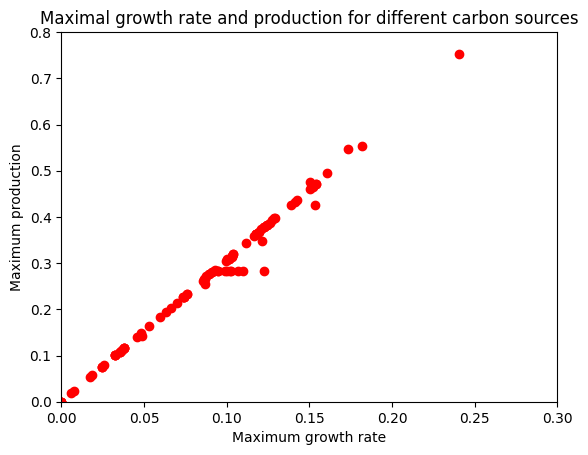

In [9]:
# A scatterplot of the production over growth to view the distribution is created
plt.scatter(df.get('Growth'), df.get('Production'),c='red')
plt.xlabel('Maximum growth rate')
plt.ylabel('Maximum production')
plt.xlim(0, 0.3)
plt.ylim(0, 0.8)
plt.title('Maximal growth rate and production for different carbon sources')
plt.savefig("figures/carbon_sources")
plt.show()

In [10]:
# Descending sort of the top 20 carbon sources leading to highest growth
df.sort_values(by='Growth', ascending=False).head(20)

,Carbon,Growth,Production
158,Maltotriose exchange,0.420673,1.296000
82,Raffinose exchange,0.419096,1.291143
7,Alpha L Arabinan exchange,0.340266,1.048286
80,Cellobiose exchange,0.269319,0.829714
157,Maltose exchange,0.269319,0.829714
127,Trehalose exchange,0.269319,0.829714
109,Sucrose exchange,0.269319,0.829714
19,Dextrin exchange,0.267743,0.824857
176,Palatinose exchange,0.267743,0.824857
106,Starch exchange,0.267743,0.824857


Maltotriose, maltose and sucrose looks promising as carbon sources, resulting in the 5th and 7th highest growth, respectively, while they also result in high production. These are selected for further investigation, as they are the most readily available carbon sources from the list, and will therefore not be too expensive to use in a medium in a production setting.

The maximum growth and production obtained from glucose is found, which will be compared to the growth and production obtained from the alternative carbon sources.

In [11]:
# Calculate the max. theoretical yield for production on glucose
with iY0844_model:
    iY0844_model.objective = iY0844_model.reactions.ALDH1_CYP71AV1
    DHAA_production_1 = iY0844_model.optimize().objective_value
    max_yield_glucose = DHAA_production_1 / (-1*iY0844_model.reactions.EX_glc__D_e.flux)
    print("Max. dihydroartemisinic acid production [mmol h^-1]:", DHAA_production_1)
    print("Theoretical max. yield [mmol-DHAA / mmol-glucose]:", max_yield_glucose) 

Max. dihydroartemisinic acid production [mmol h^-1]: 0.3634285714280042
Theoretical max. yield [mmol-DHAA / mmol-glucose]: 0.21378151260470837


In [12]:
# Now we convert to Cmol/Cmol
CV_DHAA = 15 # Cmol/mol conversion factor for dihydroartemisinic acid
CV_glc = 6 # Cmol/mol conversion factor for glucose

DHAA_glc_production_cmol = (max_yield_glucose*CV_DHAA)/(1*CV_glc)
print('Maximum theoretical yield cmol/cmol=', DHAA_glc_production_cmol, 'cmol-DHAA/cmol-glc')

Maximum theoretical yield cmol/cmol= 0.5344537815117709 cmol-DHAA/cmol-glc


In [13]:
# Investigating maltotriose - looking for the ID of maltotriose:
for ID in iY0844_model.reactions.query('Maltotriose exchange', 'name'):
    print(ID.id)

EX_malttr_e


In [14]:
# Changing the carbon source to maltotriose rather than glucose in our medium:
medium=iY0844_model.medium
medium['EX_glc__D_e'] = 0
medium["EX_malttr_e"]= 1.7 # set the same boundary as for base medium with glucose
iY0844_model.medium = medium
iY0844_model_maltotriose = iY0844_model
#write_sbml_model(iY0844_model, "data/iYO844_modified_maltotriose.xml") #optionally create new file with modified model on maltotriose
#iY0844_model_maltotriose = read_sbml_model('data/iYO844_modified_maltotriose.xml') #reading the new model
iY0844_model_maltotriose.medium # see that glucose has been deleted and maltotriose added

{'EX_fe3_e': 999999.0,
 'EX_ca2_e': 999999.0,
 'EX_so4_e': 5.0,
 'EX_co2_e': 999999.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_malttr_e': 1.7,
 'EX_mg2_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_nh4_e': 5.0,
 'EX_o2_e': 999999.0,
 'EX_pi_e': 5.0}

In [15]:
# Calculate the max. theoretical yield for production on maltotriose
with iY0844_model_maltotriose:
    iY0844_model_maltotriose.objective = iY0844_model_maltotriose.reactions.ALDH1_CYP71AV1
    DHAA_production_2 = iY0844_model_maltotriose.optimize().objective_value
    max_yield_maltotriose = DHAA_production_2 / (-1*iY0844_model_maltotriose.reactions.EX_malttr_e.flux)
    print("Max. dihydroartemisinic acid production [mmol h^-1]:", DHAA_production_2)
    print("Theoretical max. yield [mmol-DHAA / mmol-maltotriose]:", max_yield_maltotriose)

Max. dihydroartemisinic acid production [mmol h^-1]: 1.2959999999994327
Theoretical max. yield [mmol-DHAA / mmol-maltotriose]: 0.762352941176137


In [16]:
# Now we convert to Cmol/Cmol
CV_DHAA = 15 # Cmol/mol conversion factor for dihydroartemisinic acid
CV_malttr = 18 # Cmol/mol conversion factor for maltotriose

DHAA_maltotriose_production_cmol = (max_yield_maltotriose*CV_DHAA)/(1*CV_malttr)
print('Maximum theoretical yield cmol/cmol=', DHAA_maltotriose_production_cmol, 'cmol-DHAA/cmol-maltotriose')

Maximum theoretical yield cmol/cmol= 0.6352941176467808 cmol-DHAA/cmol-maltotriose


In [17]:
# Secondly, investigation of maltose. Finding the ID of maltose
for ID in iY0844_model.reactions.query('Maltose exchange', 'name'):
    print(ID.id)

EX_malt_e


In [18]:
# Changing the carbon source to maltose in our medium:
medium=iY0844_model.medium
medium['EX_glc__D_e'] = 0
medium["EX_malttr_e"]= 0
medium["EX_malt_e"]= 1.7 # set the same boundary as for base medium w. glucose
iY0844_model.medium = medium
iY0844_model_maltose = iY0844_model
#write_sbml_model(iY0844_model, "data/iYO844_modified_maltose.xml") # create new file with modified model on maltose
#iY0844_model_maltose = read_sbml_model('data/iYO844_modified_maltose.xml')
iY0844_model_maltose.medium # see that glucose has been deleted and maltose added

{'EX_fe3_e': 999999.0,
 'EX_ca2_e': 999999.0,
 'EX_so4_e': 5.0,
 'EX_co2_e': 999999.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_malt_e': 1.7,
 'EX_mg2_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_nh4_e': 5.0,
 'EX_o2_e': 999999.0,
 'EX_pi_e': 5.0}

In [19]:
# Calculate the max. theoretical yield for production on maltose
with iY0844_model_maltose:
    iY0844_model_maltose.objective = iY0844_model_maltose.reactions.ALDH1_CYP71AV1
    DHAA_production_3 = iY0844_model_maltose.optimize().objective_value
    max_yield_maltose = DHAA_production_3 / (-1*iY0844_model_maltose.reactions.EX_malt_e.flux)
    print("Max. dihydroartemisinic acid production [mmol h^-1]:", DHAA_production_3)
    print("Theoretical max. yield [mmol-DHAA / mmol-maltose]:", max_yield_maltose)

Max. dihydroartemisinic acid production [mmol h^-1]: 0.829714285713718
Theoretical max. yield [mmol-DHAA / mmol-maltose]: 0.48806722689042237


In [20]:
# Now we convert to Cmol/Cmol
CV_DHAA = 15 # Cmol/mol conversion factor for dihydroartemisinic acid
CV_malt = 12 # Cmol/mol conversion factor for maltose

DHAA_maltose_production_cmol = (max_yield_maltose*CV_DHAA)/(1*CV_malt)
print('Maximum theoretical yield cmol/cmol=', DHAA_maltose_production_cmol, 'cmol-DHAA/cmol-maltose')

Maximum theoretical yield cmol/cmol= 0.610084033613028 cmol-DHAA/cmol-maltose


In [21]:
# Lastly, we investigate sucrose - we look for the ID of sucrose:
for ID in iY0844_model.reactions.query('Sucrose exchange', 'name'):
    print(ID.id)

EX_sucr_e


In [22]:
# Changing the carbon source to sucrose in our medium:
medium=iY0844_model.medium
medium['EX_glc__D_e'] = 0
medium["EX_malttr_e"]= 0 
medium["EX_malt_e"]= 0
medium["EX_sucr_e"]= 1.7 # set the same boundary as for base medium w. glucose
iY0844_model_sucrose = iY0844_model
iY0844_model_sucrose.medium = medium
#write_sbml_model(iY0844_model, "data/iYO844_modified_sucrose.xml") # create new file with modified model on sucrose
#iY0844_model_sucrose = read_sbml_model('data/iYO844_modified_sucrose.xml')
iY0844_model_sucrose.medium # see that glucose has been deleted and sucrose added

{'EX_fe3_e': 999999.0,
 'EX_ca2_e': 999999.0,
 'EX_so4_e': 5.0,
 'EX_co2_e': 999999.0,
 'EX_sucr_e': 1.7,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_mg2_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_nh4_e': 5.0,
 'EX_o2_e': 999999.0,
 'EX_pi_e': 5.0}

In [23]:
# Calculate the max. theoretical yield for production on sucrose
with iY0844_model_sucrose:
    iY0844_model_sucrose.objective = iY0844_model_sucrose.reactions.ALDH1_CYP71AV1
    DHAA_production_4 = iY0844_model_sucrose.optimize().objective_value
    max_yield_sucrose = DHAA_production_4 / (-1*iY0844_model_sucrose.reactions.EX_sucr_e.flux)
    print("Max. dihydroartemisinic acid production [mmol h^-1]:", DHAA_production_4)
    print("Theoretical max. yield [mmol-DHAA / mmol-sucrose]:", max_yield_sucrose)

Max. dihydroartemisinic acid production [mmol h^-1]: 0.8297142857137189
Theoretical max. yield [mmol-DHAA / mmol-sucrose]: 0.48806722689042287


In [24]:
# Now we convert to Cmol/Cmol
CV_DHAA = 15 # Cmol/mol conversion factor for dihydroartemisinic acid
CV_sucr = 12 # Cmol/mol conversion factor for sucrose

DHAA_sucrose_production_cmol = (max_yield_sucrose*CV_DHAA)/(1*CV_sucr)
print('Maximum theoretical yield cmol/cmol=', DHAA_sucrose_production_cmol, 'cmol-DHAA/cmol-sucrose')

Maximum theoretical yield cmol/cmol= 0.6100840336130285 cmol-DHAA/cmol-sucrose


### Visualisation of results

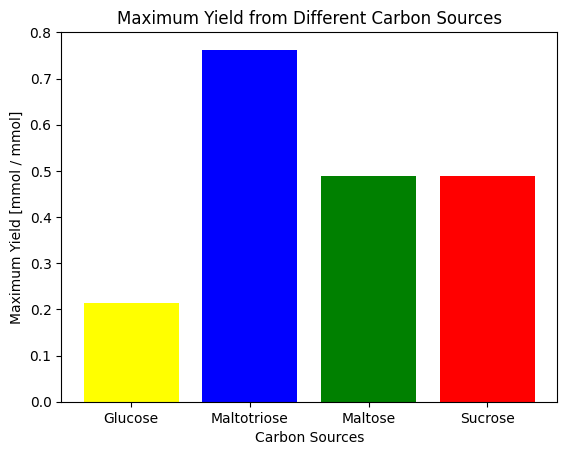

In [25]:
# Generate bar plot to visualize mmol/mmol

# Write values
yield_glucose = max_yield_glucose
yield_maltotriose = max_yield_maltotriose
yield_maltose = max_yield_maltose
yield_sucrose = max_yield_sucrose

# Carbon sources
carbon_sources = ['Glucose', 'Maltotriose', 'Maltose', 'Sucrose']

# Maximum yields
max_yields = [yield_glucose, yield_maltotriose, yield_maltose, yield_sucrose]

# Plotting
plt.bar(carbon_sources, max_yields, color=['yellow', 'blue', 'green', 'red'])
plt.xlabel('Carbon Sources')
plt.ylabel('Maximum Yield [mmol / mmol]')
plt.title('Maximum Yield from Different Carbon Sources')
plt.show()


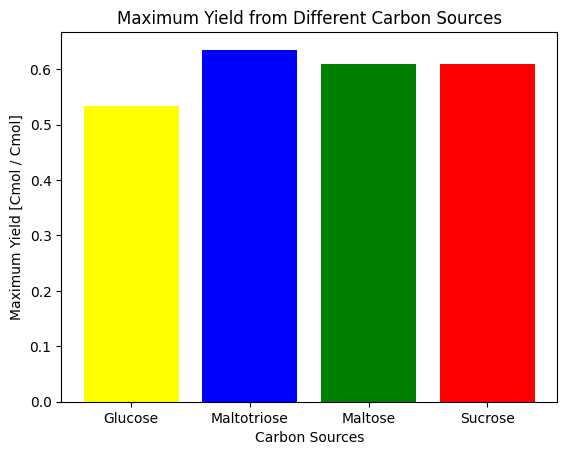

In [26]:
# Generate bar plot to visualize Cmol/Cmol

# Write values
yield_glucose_cmol = DHAA_glc_production_cmol
yield_maltotriose_cmol = DHAA_maltotriose_production_cmol
yield_maltose_cmol = DHAA_maltose_production_cmol
yield_sucrose_cmol = DHAA_sucrose_production_cmol

# Carbon sources
carbon_sources_cmol = ['Glucose', 'Maltotriose', 'Maltose', 'Sucrose']

# Maximum yields
max_yields_cmol = [yield_glucose_cmol, yield_maltotriose_cmol, yield_maltose_cmol, yield_sucrose_cmol]

# Plotting
plt.bar(carbon_sources_cmol, max_yields_cmol, color=['yellow', 'blue', 'green', 'red'])
plt.xlabel('Carbon Sources')
plt.ylabel('Maximum Yield [Cmol / Cmol]')
plt.title('Maximum Yield from Different Carbon Sources')
plt.show()
